## Introduction

The purpose of this notebook is running K-Means clustering to see if the algorithm can sucessfully cluster the news in to 'Real' & 'Fake' using just the words in the articles

## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

## Data Analysis & Cleanup

In [2]:
fake = pd.read_csv('datasets/Fake.csv')
true = pd.read_csv('datasets/True.csv')

In [23]:
fake.head(10)

,title,text,subject,date,Sentences,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Pope Francis Just Called Out Donald Trump Dur...,0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",Racist Alabama Cops Brutalize Black Boy While...,0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017","Fresh Off The Golf Course, Trump Lashes Out A...",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",Trump Said Some INSANELY Racist Stuff Inside ...,0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",Former CIA Director Slams Trump Over UN Bully...,0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",WATCH: Brand-New Pro-Trump Ad Features So Muc...,0


In [4]:
true.sample(10)

,title,text,subject,date
16083,Czech Babis gains possible support in bid for ...,PRAGUE (Reuters) - Czech billionaire Andrej Ba...,worldnews,"October 30, 2017"
25,"Trump signs tax, government spending bills int...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"December 22, 2017"
1863,"Trump administration, states headed for showdo...",WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"September 6, 2017"
16466,Pakistani court issues arrest warrant for ex-P...,ISLAMABAD (Reuters) - A Pakistani court issued...,worldnews,"October 26, 2017"
20320,Brexit law passes hurdle in reprieve for Briti...,LONDON (Reuters) - Britain s parliament backed...,worldnews,"September 10, 2017"
7167,Trump agrees to pay $25 million to settle Trum...,NEW YORK/SAN DIEGO (Reuters) - Donald Trump ag...,politicsNews,"November 18, 2016"
21378,Cambodia accuses U.S. of political interferenc...,PHNOM PENH (Reuters) - Cambodia hit back on Th...,worldnews,"August 24, 2017"
2222,U.S. diplomat engaging in back-channel diploma...,WASHINGTON (Reuters) - The United States has b...,politicsNews,"August 11, 2017"
10016,"Democrat Sanders, 'big fan of pope,' to attend...",WASHINGTON (Reuters) - U.S. Democratic preside...,politicsNews,"April 8, 2016"
7477,German justice minister says things will get m...,BERLIN (Reuters) - German Justice Minister Hei...,politicsNews,"November 9, 2016"


The first issue as seen above is that the True data contains:

1. A reuters disclaimer that the article is a tweet
> "The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump"


2. City Name and then publisher at the start
> WASHINGTON (Reuters)

so in the next block of code I remove this from the data

In [5]:
# The following is a crude way to remove the @realDonaldTrump tweet disclaimer and State/Publisher at start of text

cleansed_data = []
for data in true.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true["text"] = cleansed_data
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,While the Fake News loves to talk about my so-...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,"Together, we are MAKING AMERICA GREAT AGAIN! b...",politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017"


In [6]:
true.text[7]

'While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

Some of the text still contains various characters/words such as:

1. Links
2. Timestamps
3. Brackets
4. Numbers

So we will be removing all such characters from the real and fake data using genlib preprocessing and a custom regex for the links in preperation for the Word2Vec

Before that however, the title and text will be merged in to one so that it can all be preprocessed together. I will also add a label for real and fake which will be used later to evaluate our clustering

In [7]:
# Merging title and text
fake['Sentences'] = fake['title'] + ' ' + fake['text']
true['Sentences'] = true['title'] + ' ' + true['text']

# Adding fake and true label
fake['Label'] = 0
true['Label'] = 1

# We can merge both together since we now have labels
final_data = pd.concat([fake, true])

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['title', 'text', 'subject', 'date'], axis = 1)

final_data.head(10)

,Sentences,Label
0,"Venezuela slams Canada sanctions, says Ottawa ...",1
1,"For inspiration, new Democratic stars look to ...",1
2,U.S. House approves bill to upgrade airport se...,1
3,Iraqi forces capture North Oil Co. from Kurdis...,1
4,The Most Hated Man In Corporate America Wants...,0
5,Sandy Hook Mom SHREDS Megyn Kelly For Intervi...,0
6,One Picture At Miami Debate Watch Party For Je...,0
7,White House staff exits likely as Trump's firs...,1
8,Trump's limited appeal a warning sign for Repu...,1
9,"EU regrets U.S. withdrawal from climate deal, ...",1


In [8]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

In [9]:
for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['Sentences'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['Label'])

## Word2Vec

In [10]:
# Word2Vec model trained on processed data
model = Word2Vec(processed_data, min_count=1)

In [11]:
model.wv.most_similar("country")

[('nation', 0.8171917200088501),
 ('america', 0.625601053237915),
 ('countries', 0.5986679196357727),
 ('europe', 0.5687663555145264),
 ('world', 0.5151130557060242),
 ('dangerous', 0.4878726005554199),
 ('fear', 0.4863702058792114),
 ('societies', 0.4854908883571625),
 ('continent', 0.4843052923679352),
 ('vulnerable', 0.4785477817058563)]

## Sentence Vectors

In [12]:
# Getting the vector of a sentence based on average of all the word vectors in the sentence
# We get the average as this accounts for different sentence lengths

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

C:\Users\jarc1\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [13]:
X_np = np.array(X)
X_np.shape

(44889, 100)

## Clustering

In [14]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
Iteration 0, inertia 954535.2999182281
Iteration 1, inertia 476304.91755987593
Iteration 2, inertia 447099.6509571008
Iteration 3, inertia 444013.4778373658
Iteration 4, inertia 443675.4673594314
Iteration 5, inertia 443620.1284529821
Iteration 6, inertia 443607.85323428153
Iteration 7, inertia 443605.41890082357
Iteration 8, inertia 443604.8560730401
Converged at iteration 8: center shift 7.770744766423097e-06 within tolerance 1.1815372849039008e-05
Initialization complete
Iteration 0, inertia 781200.1158016346
Iteration 1, inertia 508028.4875400837
Iteration 2, inertia 497609.8190646899
Iteration 3, inertia 490416.72563452466
Iteration 4, inertia 479408.03814298025
Iteration 5, inertia 462860.23111258826
Iteration 6, inertia 449454.19623533287
Iteration 7, inertia 444748.57051010925
Iteration 8, inertia 443795.33514855907
Iteration 9, inertia 443640.0389835445
Iteration 10, inertia 443611.1570318767
Iteration 11, inertia 443605.75736460445
Iteration 12, inerti

In [15]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

,Sentence,Labels,Prediction
0,"[venezuela, slams, canada, sanctions, says, ot...",1,1
1,"[inspiration, new, democratic, stars, look, el...",1,0
2,"[house, approves, upgrade, airport, security, ...",1,1
3,"[iraqi, forces, capture, north, oil, kurdish, ...",1,1
4,"[hated, man, corporate, america, wants, scaram...",0,0
5,"[sandy, hook, mom, shreds, megyn, kelly, inter...",0,0
6,"[picture, miami, debate, watch, party, jeb, de...",0,0
7,"[white, house, staff, exits, likely, trump, ye...",1,1
8,"[trump, limited, appeal, warning, sign, republ...",1,0
9,"[regrets, withdrawal, climate, deal, seek, all...",1,1


The results above show that its correctly clustered them in some cases where 0 is fake news and 1 is real news

In [16]:
testing_df['assertion'] = np.logical_not(np.logical_xor(testing_df['Labels'], testing_df['Prediction']))
print(np.sum(testing_df.assertion)/np.sum(len(testing_df.assertion))*100)

87.32651651852346


## Visualization

In [17]:
# PCA of sentence vectors
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [18]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized on PCA')

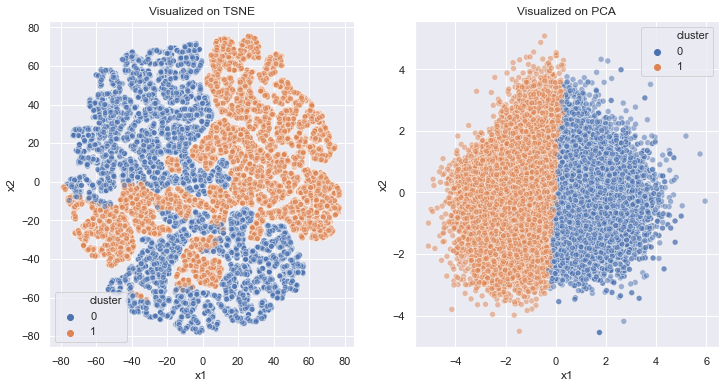

In [19]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')

## Custom News Tests

In [20]:
# Testing with fake news generated from https://www.thefakenewsgenerator.com/
onion_data = "Flint Residents Learn To Harness Superpowers, But Trump Gets Away Again They developed superpowers after years of drinking from a lead-poisoned water supply. But just having incredible abilities doesn't make them superheroes. Not yet. Donald Trump faced off against the superpowered civilians but he got away before they could catch him"

# Preprocess article
onion_data = preprocess_string(onion_data, CUSTOM_FILTERS)

# Get sentence vector
onion_data = Sentence_Vector(onion_data)

# Get prediction
kmeans.predict(np.array([onion_data]))

C:\Users\jarc1\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([0])

In [21]:
# News from BBC

bbc_data = "Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, Nasa will send a mission to Mars. The woman in charge of making the helicopter that will be sent there – which is set to become the first aircraft to fly on another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the US for access to education. She is now one of the lead engineers at Nasa. We find out what it's like being a woman in space exploration, and why her mum is her biggest inspiration."

# Preprocess article
bbc_data = preprocess_string(bbc_data, CUSTOM_FILTERS)

# Get sentence vector
bbc_data = Sentence_Vector(bbc_data)

# Get prediction
kmeans.predict(np.array([bbc_data]))

C:\Users\jarc1\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([1])